In [1]:
pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56267 sha256=f9ecbc3f7ccb3cc81f323c1d9d27d016936bf3765778e0b058eb5f8cf3aeb601
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


In [5]:
pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.0 MB/s eta 0:00:00


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import urllib

In [7]:
from mtcnn import MTCNN

In [8]:
mtcnn_model = MTCNN()

In [9]:
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image

# System libraries
import os
import random
import yaml
from tqdm import tqdm
import math

# Data analytics and visualisations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [8]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')

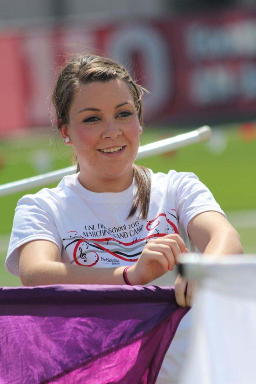

In [11]:
im = cv2.resize(image,(0,0),fx=0.25,fy=0.25)
cv2_imshow(im)

In [12]:
results = mtcnn_model.detect_faces(image) # face detection

1/1 [==============================] - 0s 356ms/step


In [14]:
for result in results:
  print(result)

{'box': [275, 336, 277, 344], 'confidence': 0.9999521970748901, 'keypoints': {'left_eye': (369, 478), 'right_eye': (497, 458), 'nose': (455, 534), 'mouth_left': (389, 599), 'mouth_right': (511, 581)}}


In [15]:
# get coordinates
x, y, w, h = result['box']
# create the shape
image = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), thickness=2)

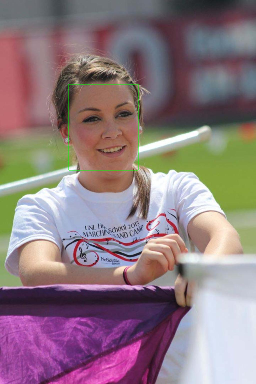

In [16]:
cv2_imshow(cv2.resize(image,(0,0),fx=0.25,fy=0.25)) # resize and display image

In [17]:
val_img_folder = f"/content/drive/MyDrive/WIDER/WIDER_val/images/"

In [18]:
val_bbx_path = f"/content/drive/MyDrive/WIDER/annotationval/wider_face_val_bbx_gt.txt"

In [21]:
# function to load the bounding boxes and return a list of them
def load_bbx(bbx_path):
    with open(bbx_path, mode='r') as file:
        lines = file.readlines()

    annotations = {}
    i = 0
    while i < len(lines):
        file_name = lines[i].strip()
        i += 1
        num_boxes = int(lines[i].strip())
        i += 1
        boxes = []
        for _ in range(num_boxes):
            box_info = lines[i].strip().split()
            box = {
                'x': int(box_info[0]),
                'y': int(box_info[1]),
                'w': int(box_info[2]),
                'h': int(box_info[3]),
            }
            boxes.append(box)
            i += 1
        annotations[file_name] = boxes

    return annotations

In [22]:
def calculate_iou(boxA, boxB):
    # Calculate the intersection coordinates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate the area of intersection
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of boxA and boxB
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calculate the IoU
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)

    return iou

# function to calculate accuracy based on IOU
def calculate_accuracy(predicted_bboxes, ground_truth_bboxes, iou_threshold):
    num_predictions = len(predicted_bboxes)
    num_ground_truth = len(ground_truth_bboxes)
    true_positives = 0

    for pred_bbox in predicted_bboxes:
        best_iou = 0
        for gt_bbox in ground_truth_bboxes:
            iou = calculate_iou(pred_bbox, gt_bbox)
            if iou > best_iou:
                best_iou = iou

        if best_iou >= iou_threshold:
            true_positives += 1

    accuracy = true_positives / num_predictions

    return accuracy

In [23]:
# load the annotations for the validation set
val_annotations = load_bbx(val_bbx_path)

val_keys = []

for key in val_annotations.keys():
    val_keys.append(key)

In [24]:
# function to define the ground truth box
def annot_box(annotation):
  annot_box = []
  for box in annotation:
    x = box['x']
    y=box['y']
    w=box['w']
    h=box['h']

    annot_box.append([x,y,x+w,y+h])

  return annot_box

In [25]:
# function that accepts the results and creates bounding boxes for the face
def result_box(results):
  result_box = []
  for result in results:
    x = result['box'][0]
    y = result['box'][1]
    w = result['box'][2]
    h = result['box'][3]

    result_box.append([x,y,x+w,y+h])

  return result_box

In [ ]:
ground_box = []
pred_box = []
for key in val_keys[:100]: # only first 100 images are considers from the validation set
  ground_box.extend(annot_box(val_annotations[key])) # add the ground truth bounding box to the ground truth list
  img = np.array(Image.open(f"{val_img_folder}{key}")) # load the image
  results = mtcnn_model.detect_faces(img) # predict the face
  pred_box.extend(result_box(results))# add the bounding box to the prediction list

In [27]:
iou_threshold = 0.5 #set an IOU threshold
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate accuracy
print('Model accuracy:', accuracy*100) # baseline accuracy of the model

Model accuracy: 95.51569506726457


##Gaussian Noise

In [29]:
def add_gaussian_noise(image, stddev):

  # Generate Gaussian noise
  mean = 0
  noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)

  # Add the generated noise to the image
  noisy_image = cv2.add(image, noise)

  return noisy_image

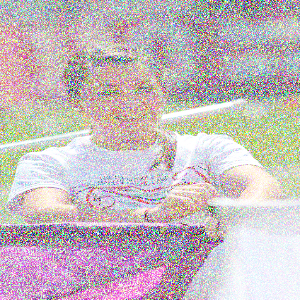

In [30]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = add_gaussian_noise(image,10)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [ ]:
noise_param = [5,10,25,50] # Sigma values for gaussian noise
noise_accuracy = []

In [ ]:
for noise in noise_param:
  ground_box = []
  pred_box = []
  for key in val_keys[:100]:
    ground_box.extend(annot_box(val_annotations[key]))
    img = np.array(Image.open(f"{val_img_folder}{key}")) # open image
    img = add_gaussian_noise(img,noise)  # add the gaussian noise of a particular sigma value in the list
    results = mtcnn_model.detect_faces(img)
    pred_box.extend(result_box(results))
  iou_threshold = 0.5
  accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate the accuracies for each sigma
  noise_accuracy.append(accuracy) # append the accuracy to plot a graph

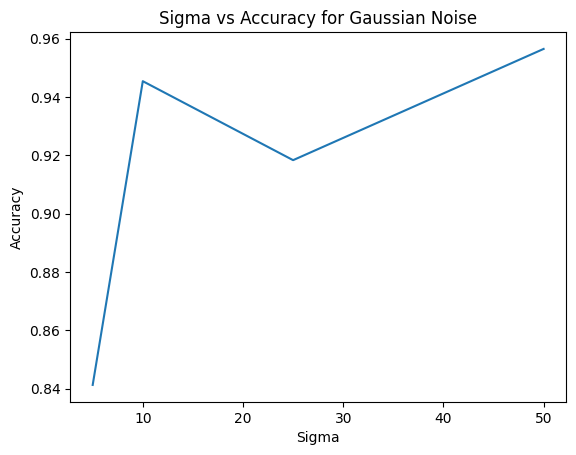

In [ ]:
# plot Sigma vs Accuracy for Gaussian Noise
plt.plot(noise_param,noise_accuracy)
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.title('Sigma vs Accuracy for Gaussian Noise')
plt.show()

##Gaussian Blur

In [31]:
def add_gaussian_blur(image, kernel_size, sigma):

  # Apply Gaussian blur of given kernel and sigma to the image
  blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)

  return blurred_image

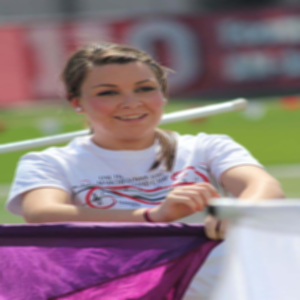

In [32]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = add_gaussian_blur(image,(15,15),50.0)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [ ]:
blur_param = [2,5,10,25,70] # sigma values for gaussian blur
blur_accuracy = []

In [ ]:
for blur in blur_param:
  ground_box = []
  pred_box = []
  for key in val_keys[:100]:
    ground_box.extend(annot_box(val_annotations[key]))
    img = np.array(Image.open(f"{val_img_folder}{key}")) # open the image
    img = add_gaussian_blur(img,(15,15),blur) # add the gaussian blur for each sigma value in the list
    results = mtcnn_model.detect_faces(img)
    pred_box.extend(result_box(results))
  iou_threshold = 0.5
  accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate the accuracy for different sigma values
  blur_accuracy.append(accuracy) # append the accuracies to a list to plot a graph

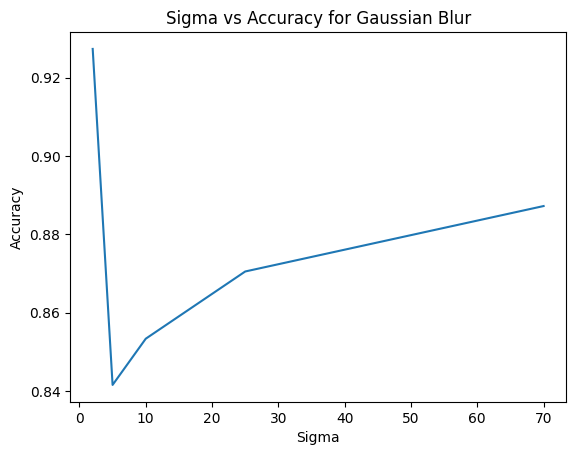

In [ ]:
# plot sigma vs accuracy
plt.plot(blur_param,blur_accuracy)
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.title('Sigma vs Accuracy for Gaussian Blur')
plt.show()

##Leopard Print

In [34]:
from noise import snoise2
# function to generate a mask by thresholding a 2D simplex noise and applies it to the image to hide the face
def leopard_noise(image, threshold):

  # Get image dimensions
  height, width = image.shape[:2]

  frequency = 1 / 150

  # Generate 2D simplex noise
  noise_image = np.zeros((height, width))
  for y in range(height):
      for x in range(width):
          noise_image[y, x] = snoise2(x * frequency, y * frequency)

  # Normalize noise image to [0, 1]
  noise_image = (noise_image - np.min(noise_image)) / (np.max(noise_image) - np.min(noise_image))

  # Threshold the noise image to create the mask
  mask = np.where(noise_image < threshold, 1, 0)

  # Expand the mask to three channels for compatibility with the image
  mask = np.expand_dims(mask, axis=2)
  mask = np.repeat(mask, 3, axis=2)

  # Apply the mask to the image to hide the face
  masked_image = np.where(mask == 1, 0, image)

  return masked_image

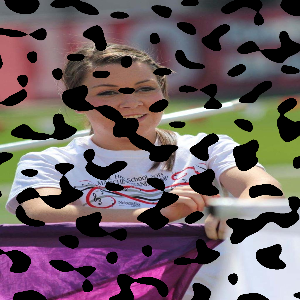

In [35]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = leopard_noise(image, 0.3)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [ ]:
leopard_ = [0.3,0.4,0.5,0.6] # different thresholds
leopard_accuracy = []

In [ ]:
for thres in leopard_:
  ground_box = []
  pred_box = []
  for key in val_keys[:100]:
    ground_box.extend(annot_box(val_annotations[key]))
    img = np.array(Image.open(f"{val_img_folder}{key}")) # open the image
    img = leopard_noise(img, thres) # apply leopard spots at that threshold
    results = mtcnn_model.detect_faces(img)
    pred_box.extend(result_box(results))
  iou_threshold = 0.5
  accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate accuracy for different thresholds
  leopard_accuracy.append(accuracy) # append accuracy to plot graph

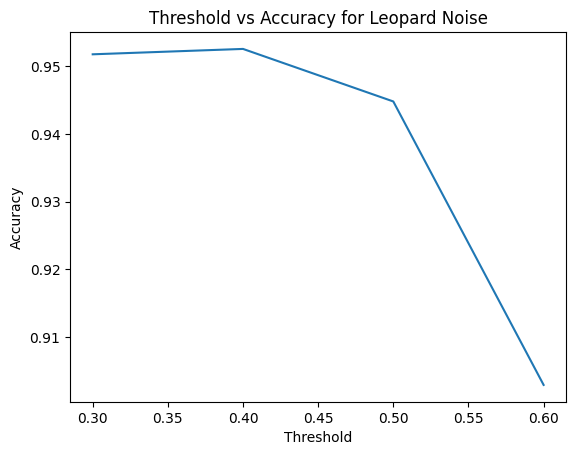

In [ ]:
# Threshold vs accuracy plot for leopard spots
plt.plot(leopard_,leopard_accuracy)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Accuracy for Leopard Noise')
plt.show()

## Darken Image

In [41]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

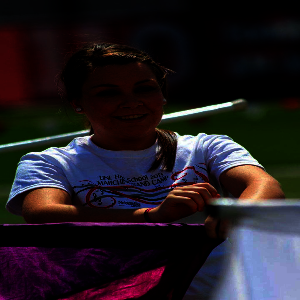

In [54]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = adjust_gamma(image,0.2)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [55]:
dark_factor = [0.1,0.2,0.3,0.5] # different factors to darken the image
dark_accuracy = []

In [ ]:
for factor in dark_factor:
  ground_box = []
  pred_box = []
  for key in val_keys[:100]:
    ground_box.extend(annot_box(val_annotations[key]))
    img = np.array(Image.open(f"{val_img_folder}{key}")) # open image
    img = adjust_gamma(img,factor) # darken image according to the factor
    results = mtcnn_model.detect_faces(img) # predict the face
    pred_box.extend(result_box(results)) # append the box to the prediction list
  iou_threshold = 0.5
  accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate accuracy for different factors
  dark_accuracy.append(accuracy) # append to list to plot graph

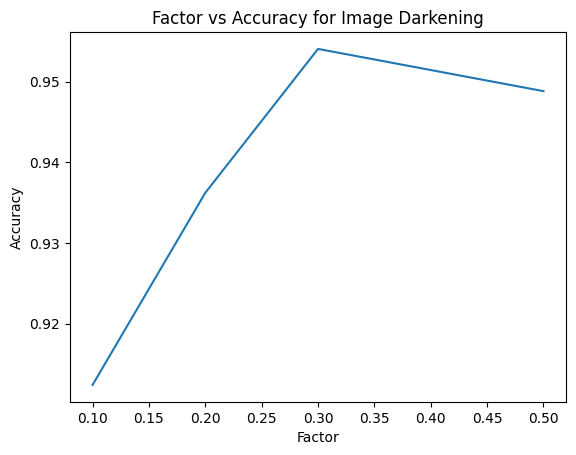

In [57]:
# plot factor vs accuracy for darkening
plt.plot(dark_factor,dark_accuracy)
plt.xlabel('Factor')
plt.ylabel('Accuracy')
plt.title('Factor vs Accuracy for Image Darkening')
plt.show()

## Censoring Eyes

In [236]:
def line_through_eyes(image, results, color= 'white', thickness_factor=0.19):
  for result in results:
    if 'left_eye' in result['keypoints'] and 'right_eye' in result['keypoints']:
        left_eye = result['keypoints']['left_eye']
        right_eye = result['keypoints']['right_eye']

        # Calculate the distance between the left and right eye keypoints
        eye_distance = np.linalg.norm(np.array(left_eye) - np.array(right_eye))

        # Calculate the thickness based on the eye size
        thickness = int(eye_distance * thickness_factor)
        thickness = max(thickness, 5)  # Ensure thickness is at least 5

        if color == 'white':

        # Draw the line through the eyes depending on colour

          cv2.line(image, tuple(left_eye), tuple(right_eye), (255,255,255), thickness)

        else:

          cv2.line(image, tuple(left_eye), tuple(right_eye), (0,0,0), thickness)

  return image

1/1 [==============================] - 0s 19ms/step


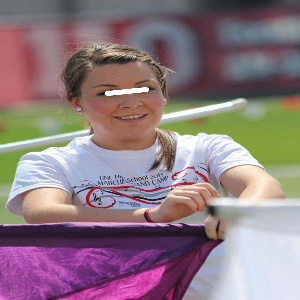

In [59]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
results = mtcnn_model.detect_faces(image)
image = line_through_eyes(image,results)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

#### Censoring Eyes White

In [ ]:
7ground_box = []
pred_box = []
for key in val_keys[:100]:
  ground_box.extend(annot_box(val_annotations[key]))
  img = np.array(Image.open(f"{val_img_folder}{key}"))# open image
  results = mtcnn_model.detect_faces(img) # predict eye region
  img = line_through_eyes(img,results) # draw white line through the eye (function is default white)
  results = mtcnn_model.detect_faces(img) # predict if the image is detected with lines
  pred_box.extend(result_box(results))

In [61]:
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold)
print("Accuracy with white lines through eyes:",accuracy*100)

Accuracy with white lines through eyes: 95.75070821529745


####Line Through Eyes Black

In [ ]:
ground_box = []
pred_box = []
for key in val_keys[:100]:
  ground_box.extend(annot_box(val_annotations[key]))
  img = np.array(Image.open(f"{val_img_folder}{key}")) # open image
  results = mtcnn_model.detect_faces(img) # predict eye region
  img = line_through_eyes(img,results,'black') # draw black line through the eye
  results = mtcnn_model.detect_faces(img) # predict if the image is detected with lines
  pred_box.extend(result_box(results))

In [63]:
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold)
print("Accuracy with black lines through eyes:",accuracy*100)

Accuracy with black lines through eyes: 96.42857142857143


##Rotation

In [64]:
def rotate_image(image, angle):

  # Obtain the image dimensions
  height, width = image.shape[:2]

  # Calculate the rotation matrix
  rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)

  # Perform the image rotation
  rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

  return rotated_image

In [65]:
# function to rotate the box co-ordinates
def rotate_box(image,ls,angle):

  x, y, x1, y1 = ls # box co-ordinates
  w = x1 - x
  h = y1 - y

  points = np.array([(x, y), (x + w, y), (x + w, y + h), (x, y + h)], dtype=np.float32)

  height, width = image.shape[:2]

  rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0) # get the rotation matrix

  # Convert the points to homogeneous coordinates [x, y, 1]
  homogeneous_points = np.concatenate((points, np.ones((4, 1))), axis=1)

  rotated_points = np.dot(rotation_matrix, homogeneous_points.T).T

  # Convert back to Cartesian coordinates [x, y]
  rotated_bounding_box = rotated_points[:, :2].astype(np.int32)

  x_new, y_new = np.min(rotated_bounding_box, axis=0)
  w_new, h_new = np.max(rotated_bounding_box, axis=0) - np.array([x_new, y_new])

  rotated_box = [x_new,y_new,x_new+w_new,y_new+h_new] # new co-ordinates

  return rotated_box

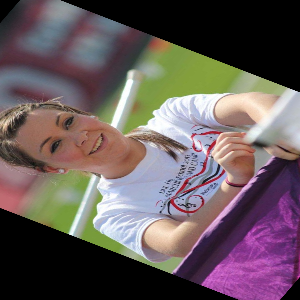

In [66]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = rotate_image(image,60)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [ ]:
ground_box = []
pred_box = []
for key in val_keys[:100]:
  img = np.array(Image.open(f"{val_img_folder}{key}")) # open the image
  rot_box = [] # define a new list for the rotated box co-ordinates
  for box in annot_box(val_annotations[key]):
    rot_box.append(rotate_box(img,box,60)) # rotated the bounding box
  ground_box.extend(rot_box) # append the rotated bounding box to the ground truth box as this is our new ground truth
  img = rotate_image(img,60) # rotate the image
  results = mtcnn_model.detect_faces(img) # predict the face region
  pred_box.extend(result_box(results)) # append predicted box to the list

In [ ]:
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate accuracy
print('Model accuracy for rotation:', accuracy)

0.41379310344827586

##Swirl

In [ ]:
def swirl_image(image, strength, radius,center):

  # Convert the image to float32 for accurate calculations
  image = image.astype(np.float32)

  # Get the height and width of the image
  height, width = image.shape[:2]

  # Generate a grid of coordinates
  y, x = np.mgrid[0:height, 0:width]
  y = y.astype(np.float32) - center[1]
  x = x.astype(np.float32) - center[0]

  # Calculate the distance from the center
  distance = np.sqrt(x**2 + y**2)

  # Calculate the angle of rotation
  angle = strength * np.exp(-distance / radius) * distance

  # Apply the polar coordinate transformation
  x_new = x * np.cos(angle) + y * np.sin(angle) + center[0]
  y_new = -x * np.sin(angle) + y * np.cos(angle) + center[1]

  # Interpolate the new pixel values
  swirled_image = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LINEAR)

  return swirled_image

1/1 [==============================] - 0s 31ms/step


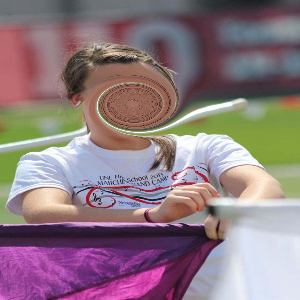

In [ ]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
results = mtcnn_model.detect_faces(image)
center = results[0]['keypoints']['nose']
image = swirl_image(image,10,20,center)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [ ]:
ground_box = []
pred_box = []
for key in val_keys[:100]:
  ground_box.extend(annot_box(val_annotations[key]))
  img = np.array(Image.open(f"{val_img_folder}{key}")) # open image
  nose_points=[]
  results = mtcnn_model.detect_faces(img) # find where the nose is (center point for our swirl)
  for result in results:
    nose_points.append(result['keypoints']['nose']) # append the noise point (can be multiple as there can be multiple faces)
    # We are getting only one left and right eye to calculate the radius of the swirl
    left_eye = result['keypoints']['left_eye']
    right_eye = result['keypoints']['right_eye']
  eye_distance = np.linalg.norm(np.array(left_eye) - np.array(right_eye)) # calculate distance between left and right eye
  radius = 0.5*eye_distance # swirl radius is factor of eye distance
  for point in nose_points: # for all available nose point apply swirl
    img = swirl_image(img,10,radius,point)
  results = mtcnn_model.detect_faces(img) # detect face with swirl
  pred_box.extend(result_box(results))

In [ ]:
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate accuracy
print(accuracy)

0.746031746031746


##New Noise

### Invert Image

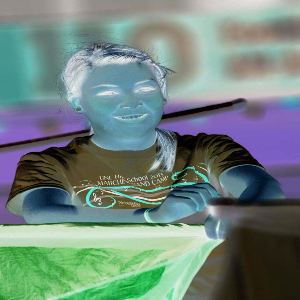

In [239]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = 255-image
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [ ]:
ground_box = []
pred_box = []
for key in val_keys[:100]:
  ground_box.extend(annot_box(val_annotations[key]))
  img = np.array(Image.open(f"{val_img_folder}{key}")) # open image
  img = 255-img
  results = mtcnn_model.detect_faces(img) # predict face bounding box
  pred_box.extend(result_box(results))

In [241]:
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate accuracy
print('Accuracy for Inverted Image:',accuracy*100)

Accuracy for Inverted Image: 30.0


Random Noise Subtraction

In [260]:
def sub_random_noise(image):

  # Generate Random noise
  noise = np.random.randint(0, 255, image.shape).astype(np.uint8)

  # Subtract the generated noise from the image
  noisy_image = cv2.subtract(image, noise)

  return noisy_image

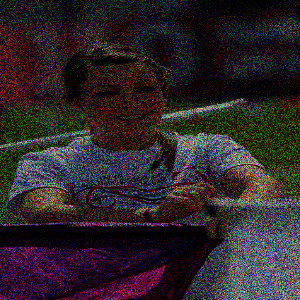

In [261]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = sub_random_noise(image)
image = cv2.resize(image,(300,300))
cv2_imshow(image)

In [ ]:
ground_box = []
pred_box = []
for key in val_keys[:100]:
  ground_box.extend(annot_box(val_annotations[key]))
  img = np.array(Image.open(f"{val_img_folder}{key}")) # open image
  img = sub_random_noise(img)
  results = mtcnn_model.detect_faces(img) # predict face bounding box
  pred_box.extend(result_box(results))

In [263]:
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate accuracy
print('Accuracy for Noise Subtracted Image:',accuracy*100)

Accuracy for Noise Subtracted Image: 98.07692307692307


### Random Placement of Adversarial Patch

In [230]:
def random_patch_overlay(main_image,transparency=1):

  patch_image = cv2.imread('/content/drive/MyDrive/images1.png')
  patch_image = cv2.resize(patch_image,(250,250))

  # Get the dimensions of the main image and patch image
  main_height, main_width = main_image.shape[:2]
  patch_height, patch_width = patch_image.shape[:2]

  # Randomly choose the position to place the patch
  x_position = random.randint(0, main_width - patch_width)
  y_position = random.randint(0, main_height - patch_height)

  # Create a region of interest (ROI) for the patch
  roi = main_image[y_position:y_position + patch_height, x_position:x_position + patch_width]

  # Add the patch to the main image at the random position
  overlay = cv2.addWeighted(roi, 0, patch_image, 1, 0)
  main_image[y_position:y_position + patch_height, x_position:x_position + patch_width] = overlay

  # Save the result
  return main_image

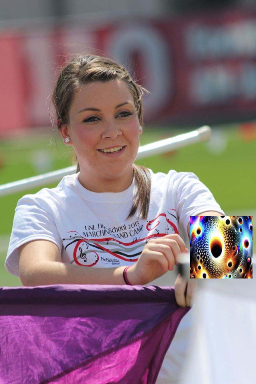

In [231]:
image = cv2.imread('/content/drive/MyDrive/image.jpg')
image = random_patch_overlay(image)
im = cv2.resize(image,(0,0),fx=0.25,fy=0.25)
cv2_imshow(im)

In [ ]:
ground_box = []
pred_box = []
for key in val_keys[:100]:
  ground_box.extend(annot_box(val_annotations[key]))
  img = np.array(Image.open(f"{val_img_folder}{key}")) # open image
  img = random_patch_overlay(img)  # add the patch
  results = mtcnn_model.detect_faces(img)
  pred_box.extend(result_box(results))
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold) # calculate the accuracy

In [233]:
iou_threshold = 0.5
accuracy = calculate_accuracy(pred_box,ground_box, iou_threshold)
print('Accuracy for random placement of Adverserial Patch:',accuracy*100)

Accuracy for random placement of Adverserial Patch: 94.79166666666666


Adversarial Eye Patch

Placed an eye patch manually on 10 images to see if the model is detecting the face

In [273]:
image = cv2.imread('/content/drive/MyDrive/Eye_Patch/13_Interview_Interview_2_People_Visible_13_204.jpg')
results = mtcnn_model.detect_faces(image)

1/1 [==============================] - 0s 24ms/step


(-0.5, 511.5, 303.5, -0.5)

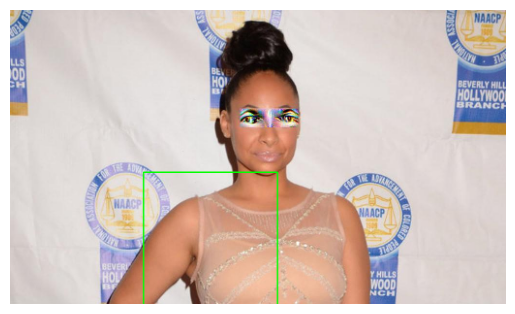

In [278]:
# get coordinates
x, y, w, h = result['box']
# create the shape
image = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), thickness=2)
im = cv2.resize(image,(0,0),fx=0.5,fy=0.5)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.axis('off')

In [ ]:
# Path to the folder containing your images
folder_path = '/content/drive/MyDrive/Eye_Patch'
images = []

# Get a list of all the files in the folder
image_files = os.listdir(folder_path)

# Loop through each image file and open them one by one
for file in image_files:
    # Join the file name with the folder path to get the full file path
    file_path = os.path.join(folder_path, file)

  # Check if the file is an image (you can add more image file extensions if needed)
      # Read the image using OpenCV
    image = cv2.imread(file_path)

    if image is not None:
      # Display the image
      results = mtcnn_model.detect_faces(image)
      x, y, w, h = result['box']
      # create the shape
      image = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), thickness=5)
      im = cv2.resize(image,(600,600))
      im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

      images.append(im)

    else:
        print(f"Unable to read image: {file_path}")

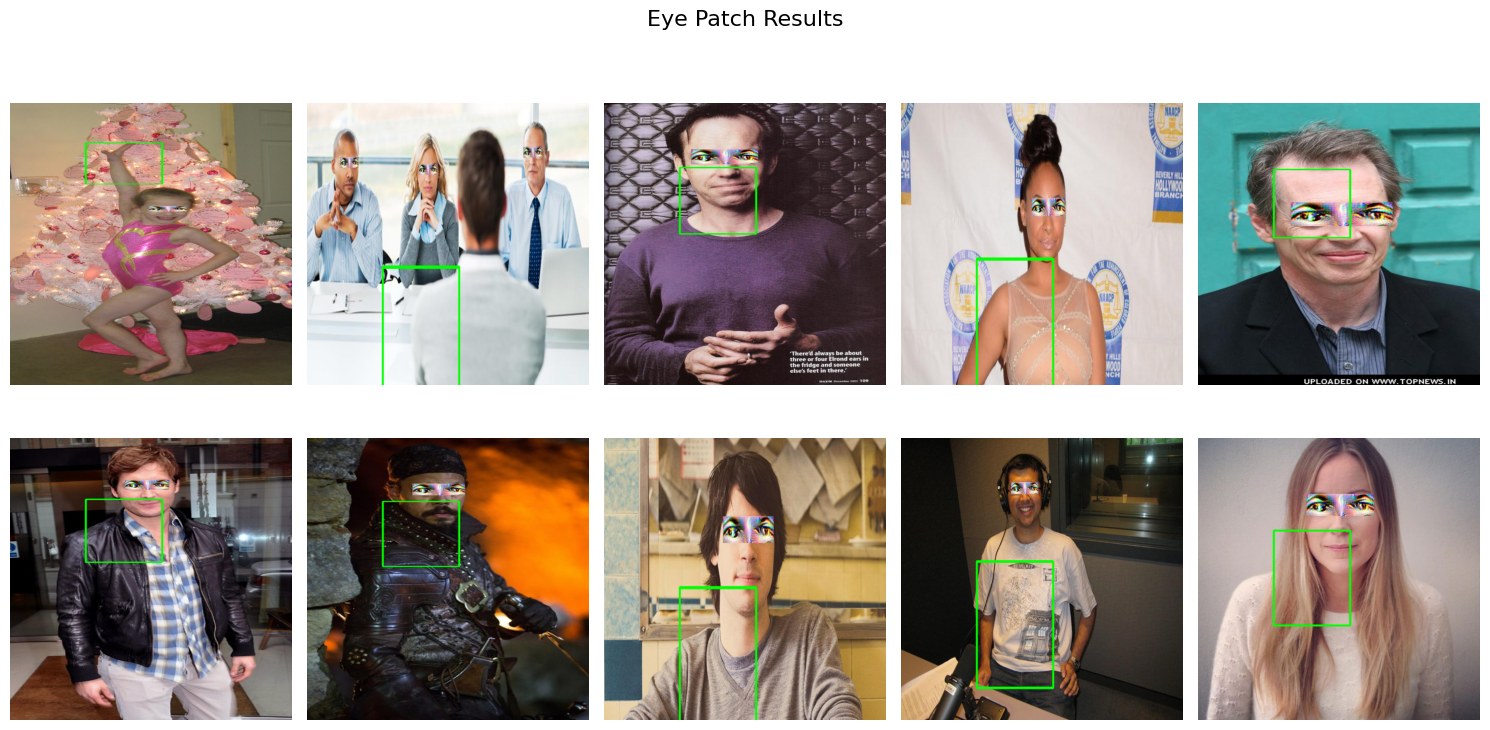

In [293]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Loop through the images and plot them on each subplot
for i, ax in enumerate(axes.flat):
  # Load the image (replace with your own image loading function)
  image = images[i]
  ax.imshow(image)
  ax.axis('off')
fig.suptitle("Eye Patch Results",fontsize=16)
plt.tight_layout()
plt.show()

Although the MTCNN model appears to make predictions it rarely predicts in the region of an actually present face. So the reliability of the predictions is poor. Even thoughough the images are not drastically changed.  

In [ ]:
# Path to the folder containing your images
folder_path = '/content/drive/MyDrive/AdvPatchClothing'
images = []

# Get a list of all the files in the folder
image_files = os.listdir(folder_path)

# Loop through each image file and open them one by one
for file in image_files:
    # Join the file name with the folder path to get the full file path
    file_path = os.path.join(folder_path, file)

  # Check if the file is an image (you can add more image file extensions if needed)
      # Read the image using OpenCV
    image = cv2.imread(file_path)

    if image is not None:
      # Display the image
      results = mtcnn_model.detect_faces(image)
      for result in results:
        x, y, w, h = result['box']
        # create the shape
        image = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), thickness=5)
        im = cv2.resize(image,(600,600))
        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

        images.append(im)

    else:
        print(f"Unable to read image: {file_path}")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


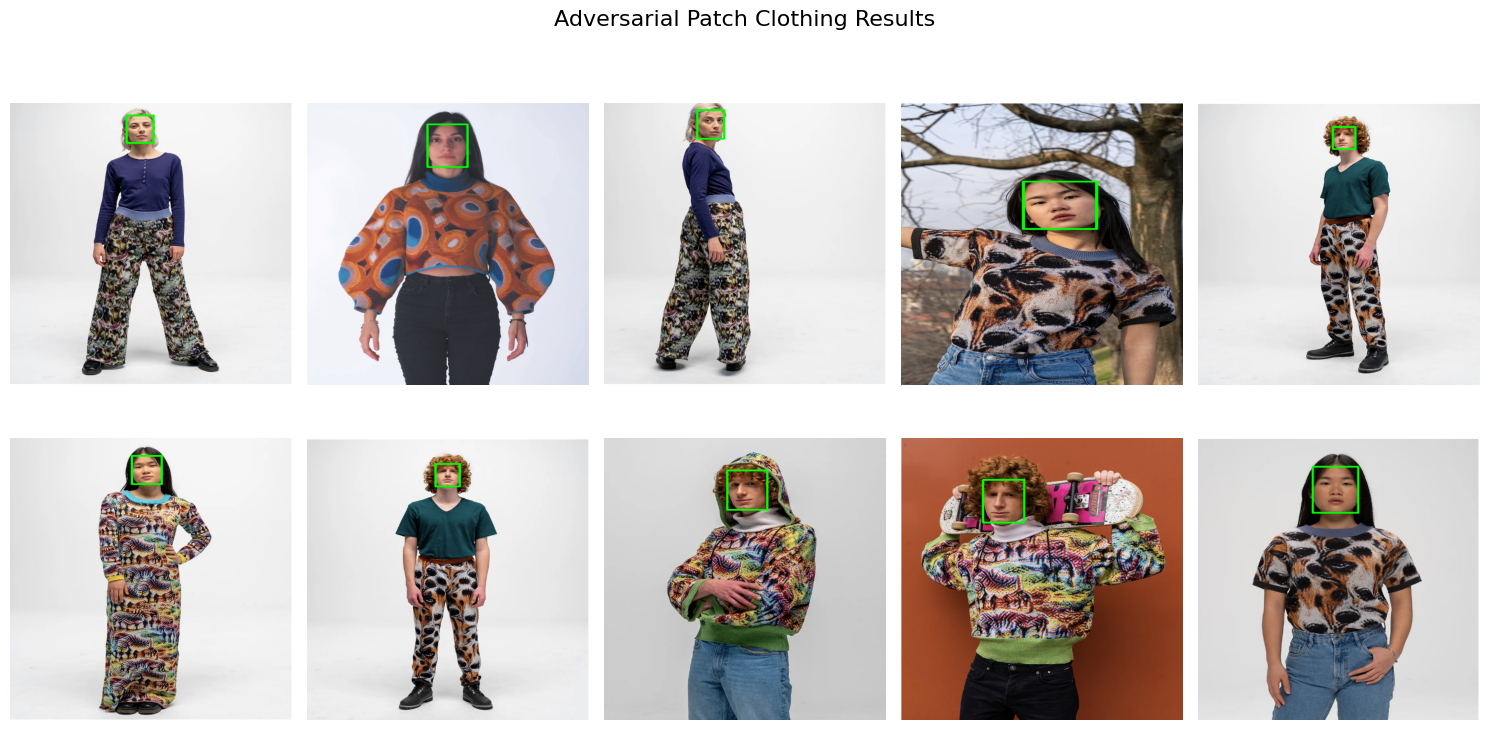

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Loop through the images and plot them on each subplot
for i, ax in enumerate(axes.flat):
  # Load the image (replace with your own image loading function)
  image = images[i]
  ax.imshow(image)
  ax.axis('off')
fig.suptitle("Adversarial Patch Clothing Results",fontsize=16)
plt.tight_layout()
plt.show()

Source: <br>

[1] ChatGPT, response to author query. OpenAI [Online]. https://chatgpt.pro/ (accessed June 15, 2023).

[2] OpenCV, tutorial [Online]. https://docs.opencv.org/4.x/d9/df8/tutorial_root.html (accessed June 15,2023)

